All the skin cancer detection tasks are based around the ISIC 2017 Challenge:
https://www.isic-archive.com/#!/topWithHeader/tightContentTop/challenges
Which has numerous tasks, part 1 being semantic segmentaion of skin lesions,
and part 3 for classification between 3 forms of skin lesion.


This script assumes a certain stucture within the data directory (PATH).
There are four main datasets used;
1. ISIC 2017 Challenge (will have to create a login https://challenge.kitware.com/#phase/5840f53ccad3a51cc66c8dab)
    Paths used, and assumed in this code.
    a. Training Data (PATH/ISIC/ISIC-2017_Training_Data/) labels obtained from learningtitans rep (see below)
    b. Validation Data (PATH/ISIC/ISIC-2017_Validation_Data/) and Csv (PATH/ISIC/val_isic17.csv)
    a. Testing Data (PATH/ISIC/ISIC-2017_Test_v2_Data_Classification/) and Csv (PATH/ISIC/test_all_17.csv)
2. ISIC Archive Data (modified paths from https://github.com/learningtitans/isbi2017-part3#additional-isic-archive-images)
3. Dermofit Dataset (we paid for access - https://licensing.eri.ed.ac.uk/i/software/dermofit-image-library.html)
4. Ph2 Dataset (modified paths from https://github.com/learningtitans/isbi2017-part3#the-ph2-dataset)


The data structure and ground truths is adopted from https://github.com/learningtitans/isbi2017-part3
This is repostory from one of the top scoring teams of the ISIC 2017 Part 3 Challenge. Instructions
for ISIC Archive Data, and Ph2 datsets are in this repositoy, it also contains 'deploy2017.txt',
which I used to get the labels for all the data, except for the ISIC17p3 validation and testset.

Acessing HPC Version of all this data:
I've copied skin_cancer to the cyphy folder of HPC.
It's in /work/cyhpy/SeanMcMahon/datasets/skin_cancer
Can mount /work/cyhpy/ on your local machine for access.
To get a login to HPC, email hpc-support@qut.edu.au
Mounting script (will need to modify):
#!/bin/bash
sudo mount -t cifs //hpc-fs.qut.edu.au/work/cyphy /home/sean/hpc-cyphy -o user=n8307628,dom=QUTAD,uid=1000


By Sean McMahon - 2018

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# from jupyterthemes import jtplot
# jtplot.style()
from segmenter import *
from IPython.core.debugger import set_trace
from fastai.conv_learner import *
import create_csvs as cc
torch.cuda.is_available(), torch.backends.cudnn.enabled

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(True, True)

In [2]:
# This is the path to the all the datasets, it's also where the model weights will be stored for training later on. 
# All notebooks assume the same PATH

# I've copied skin_cancer to the cyphy folder of HPC.
# It's in /work/cyhpy/SeanMcMahon/datasets/skin_cancer
# Can mount /work/cyhpy/ on your local machine for access (hpc).
# To get a login to HPC, email hpc-support@qut.edu.au
# If not you can download all the data yourself, but will require some formatting.
PATH = Path('/home/sean/hpc-home/skin_cancer/')
%ls $PATH

dermofit/                         train_multi_mel.csv*
ISIC/                             train_multi_Mel_half.csv*
isic18_p3_test_data*              train_multi_no_ia_nervi.csv*
isic_archive/                     train_multi_raw.csv*
models/                           train_multi_raw_half_ia_nervi.csv*
ph2dataset/                       train_multi_raw_no_ia_nervi.csv*
test_isic17_dermofitLabels.csv*   train_multi_sk.csv*
tmp/                              train_mutli_SK_half.csv*
train_classes_multi_halfn.csv*    train_seg_classes_multi.csv*
train_dermofit_isic17.csv*        train_seg_isic17_dermo.csv*
train_keratosis_multi_halfn.csv*  train_seg_keratosis_multi.csv*
train_melanoma_multi_halfn.csv*   train_seg_melanoma_multi.csv*
train_Mel_seg_isic17_dermo.csv*   train_SK_seg_isic17_dermo.csv*
train_multi.csv*                  train_test_Mel_seg_isic17_dermo.csv*
train_multi_half_ia_nervi.csv*    val_isic17.csv*


In [3]:
# thesea are some of the paths assumed in my code. This should be all of them.

test_folder = 'ISIC/ISIC-2017_Test_v2_Data_Classification/'
test_csv = PATH / 'ISIC/test_isic17.csv'
val_csv = PATH / 'val_isic17.csv'
isic_trn = PATH / 'ISIC/ISIC-2017_Training_Data'
isic_val = PATH / 'ISIC/ISIC-2017_Validation_Data'
dermofit = PATH / 'dermofit'
dermofit_csv = PATH / 'dermofit/train.csv'
ph2 = PATH / 'ph2dataset/PH2_Dataset_images'
isic_archive = PATH / 'isic_archive/images/'
learningtitans_txt = PATH / 'isic_archive/recod_titans_sub/data/deploy2017.txt'

names = ['test_folder', 'test_csv', 'val_csv', 'isic_trn', 'isic_val', 
        'dermofit', 'dermofit_csv', 'ph2', 'isic_archive', 'learningtitans_txt']
dirs = [PATH / test_folder, test_csv, val_csv, isic_trn, isic_val, 
        dermofit, dermofit_csv, ph2, isic_archive, learningtitans_txt]

# Make sure these paths exist.
e_f = False
for n, d in zip(names, dirs):
    if not d.exists():
        print(f'cannot find {n}, this code assumes its existance -> "{d}"')
        e_f = True
if e_f: raise(FileNotFoundError('Some files or directories not found, they must exist for this code to work!'))

In [4]:
train_df, test_df = cc.create_half_nevus_datasets(PATH)

--- Load ISIC 17 Train set


/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


nevus        1372
melanoma      374
keratosis     254
Name: classes, dtype: int64
                                               melanoma  keratosis   classes
image                                                                       
ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg         1          0  melanoma
ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg         1          0  melanoma
--- Load Half Nevus ISIC Archive Dataset
nevus        1667
melanoma      701
keratosis       9
Name: classes, dtype: int64
                                                  melanoma  keratosis  \
image                                                                   
isic_archive/images/5436e3acbae478396759f0e5.jpg         0          0   
isic_archive/images/5593f47b9fc3c1315

0    4726
1    1221
Name: melanoma, dtype: int64
0    5385
1     562
Name: keratosis, dtype: int64


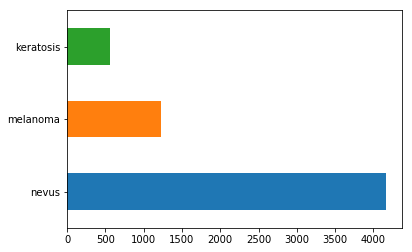

In [5]:
print(train_df['melanoma'].value_counts())
print(train_df['keratosis'].value_counts())

train_df['classes'].value_counts().plot(kind='barh')

0    483
1    117
Name: melanoma, dtype: int64
0    510
1     90
Name: keratosis, dtype: int64


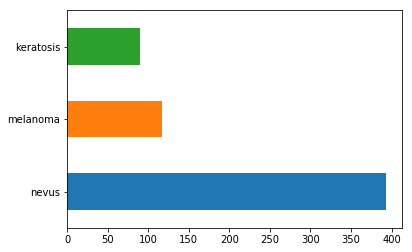

In [6]:
print(test_df['melanoma'].value_counts())
print(test_df['keratosis'].value_counts())

test_df['classes'].value_counts().plot(kind='barh')

## Segmentation of lesion images for pre-training

In [7]:
seg_trn, seg_tst = cc.create_seg_datasets(PATH)

--- Load ISIC 17 Train set
nevus        1372
melanoma      374
keratosis     254
Name: classes, dtype: int64
                                               melanoma  keratosis   classes
image                                                                       
ISIC/ISIC-2017_Training_Data/ISIC_0000000.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000001.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000002.jpg         1          0  melanoma
ISIC/ISIC-2017_Training_Data/ISIC_0000003.jpg         0          0     nevus
ISIC/ISIC-2017_Training_Data/ISIC_0000004.jpg         1          0  melanoma
--- Load Dermofit Dataset
True
nevus        967
keratosis    257
melanoma      76
Name: classes, dtype: int64
                                 melanoma  keratosis classes
dermofit/ALLBCC/D204a/D204a.png         0          0   nevus
dermofit/ALLSCC/D222/D222.png           0          0   nevus
dermofit/ALLML/D226b/D226b.png          0          0   nevu

0    3050
1     520
Name: melanoma, dtype: int64
0    3017
1     553
Name: keratosis, dtype: int64


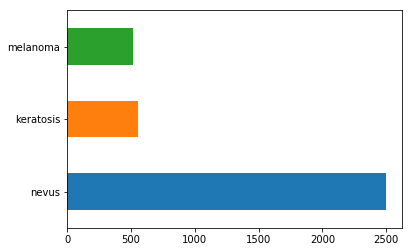

In [9]:
print(seg_trn['melanoma'].value_counts())
print(seg_trn['keratosis'].value_counts())

seg_trn['classes'].value_counts().plot(kind='barh')

0    483
1    117
Name: melanoma, dtype: int64
0    510
1     90
Name: keratosis, dtype: int64


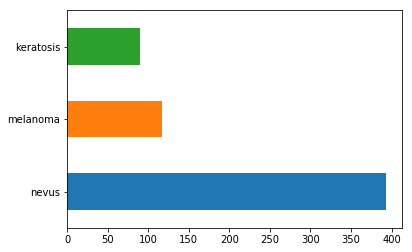

In [10]:
print(seg_tst['melanoma'].value_counts())
print(seg_tst['keratosis'].value_counts())

seg_tst['classes'].value_counts().plot(kind='barh')